In [21]:
import numba
import heapq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
import dataclasses
import timeit
import tqdm
import random
import pandas as pd
import joblib
import seaborn as sn
import itertools

# Добро пожаловать в мой ноутбук!!!

Сегодня мы бенчмаркаем A* с разными эвристиками. Объяснения будут по ходу.

Вообще я хотел написать большую прелюдию про то, как меня бесит, что в рабочих
ноутбуках понатыкано миллион бесполезных абстракций, которые алгоритм в 100
строчек превращают в невесть что, но к сожалению (для меня), у меня нет на
это времени.

In [4]:
SQRT2 = np.sqrt(2.0)

# Реализация A*

Вот реализация A*. Первое, что нужно отметить, это что я активно использую
numba для ускорения кода. Мне очень хочется запускать Дейкстру
на графах 1000*1000 по много раз в секунду, и, очевидно, чисто Python будет с
этим страдать. Jit-компиляция помогает значительно ускорить бенчмаркинг
(какая бы классная все-таки речь получилось бы про анти-ООП...).

Сам A* ничем не выделяется. На вход он принимает булев массив проходима ли клетка,
начальная и конечная клетки, функция эвристики, и булев параметр разрешается ли
перераскрытие состояний. Последний параметр нужен для ряда экспериментов с
неконсистентной эвристикой Манхеттенского расстояния, об этом позднее.

Такая реализация сразу ограничивает пространство задач, которые мы можем решать,
до 2D клеточных гридов, где каждая клетка либо проходима, либо непроходима.
Нас устраивает такое ограничение.

Tiebreak захардкоден до максимального g-значения. Исследовать его не в моих планах.

In [5]:
Result = collections.namedtuple("Result", ["found", "g_grid", "closed", "came_from_compact", "stats"])

@numba.njit
def heuristic(a, b):
    dx = np.abs(float(a[0] - b[0]))
    dy = np.abs(float(a[1] - b[1]))
    return max(dx, dy) + (SQRT2 - 1.0) * min(dx, dy)

@numba.njit
def a_star(grid, start, end, w, reexpansion=False):
    opened = [(heuristic(start, end) * w, 0.0, 0.0, start)]
    closed = np.full_like(grid, False, dtype=np.bool)
    came_from_compact = np.full_like(grid, -1, dtype=np.int64)
    g_grid = np.full_like(grid, np.inf, dtype=np.float64)
    g_grid[start] = 0.0

    stats = {
        "opened": 0,
        "closed": 0,
        "expanded": 0,
        "reopened": 0,
    }

    while len(opened) > 0:
        _, _, gv, v = heapq.heappop(opened)
        if closed[v]:
            continue

        if v == end:
            return Result(
                found=True,
                g_grid=g_grid,
                closed=closed,
                came_from_compact=came_from_compact,
                stats=stats,
            )

        vx, vy = v
        for dv, cost in (
            ((0, 1), 1.0), ((1, 0), 1.0), ((0, -1), 1.0), ((-1, 0), 1.0),
            ((1, 1), SQRT2), ((1, -1), SQRT2), ((-1, 1), SQRT2), ((-1, -1), SQRT2)
        ):
            u = (v[0] + dv[0], v[1] + dv[1])
            ux, uy = u
            if not (0 <= ux < grid.shape[0] and 0 <= uy < grid.shape[1]):
                continue
            if grid[ux, uy] or grid[vx, uy] or grid[ux, vy]:
                continue

            gu = gv + cost

            # if not reexpansion and closed[u]:
            #     assert gu >= g_grid[u] - 1e-5, f"gu: {gu}, g_grid[u]: {g_grid[u]}"

            if gu < g_grid[u] and (reexpansion or not closed[u]):
                stats["opened"] += 1
                g_grid[u] = gu
                hu = heuristic(u, end) * w
                fu = gu + hu
                heapq.heappush(opened, (fu, -gu, gu, u))
                came_from_compact[u] = vx << 32 | vy
                if reexpansion and closed[u]:
                    closed[u] = False
                    stats["reopened"] += 1

            stats["expanded"] += 1

        closed[v] = True
        stats["closed"] += 1

    return Result(
        found=False,
        g_grid=g_grid,
        closed=closed,
        came_from_compact=came_from_compact,
        stats=stats,
    )


@numba.njit
def trace_path(start, end, came_from_compact):
    path = []
    v = end
    while v != start:
        path.append(v)
        assert came_from_compact[v] != -1
        v = (came_from_compact[v] >> 32, came_from_compact[v] & ((1 << 32) - 1))
    path.append(start)
    return path[::-1]


def a_star_and_trace(grid, start, end, w, reexpansion=False):
    result = a_star(grid, start, end, w, reexpansion)
    if not result.found:
        return np.inf, result.stats, None
    path = trace_path(start, end, result.came_from_compact)
    result.stats["path_length"] = len(path)
    return result.g_grid[end], result.stats, path

Давайте посмотрим на несколько примеров работы алгоритма на разных небольших сетках.

В самой клетке можно поменять используемую эвристику.

Естественно, мне это нужно только чтобы глазами заметить очевидные баги.

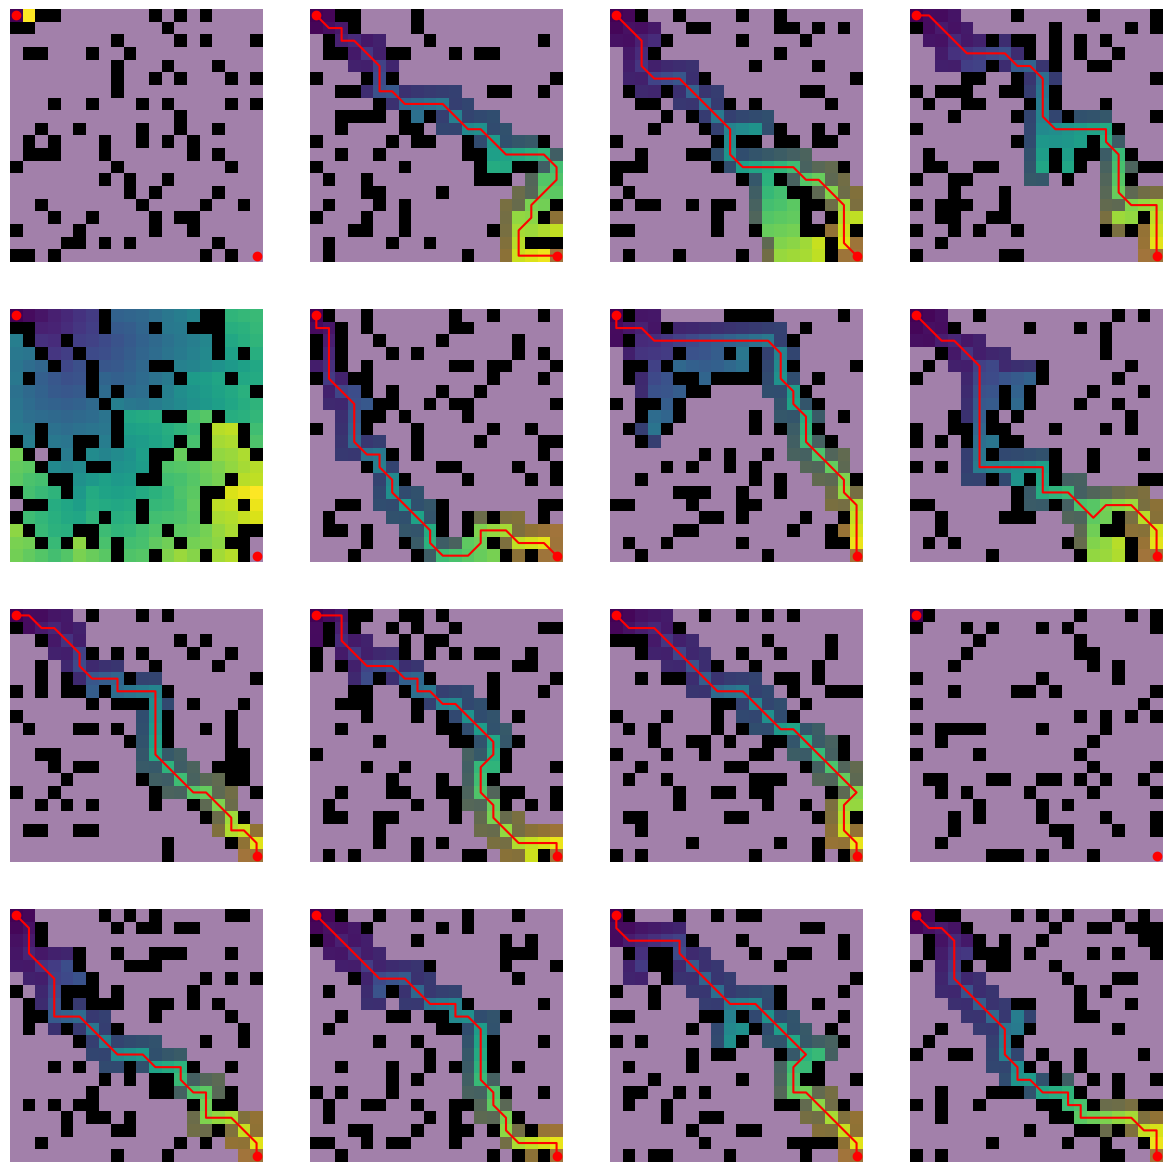

In [6]:
def visualize(grid, start, end, found, g_grid, closed, came_from, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.imshow(grid, cmap=mpl.colors.ListedColormap(['white', 'black']), alpha=grid.astype(np.float64))
    ax.imshow(g_grid, cmap='viridis', alpha=1.0)
    ax.imshow(np.ma.masked_where(~np.logical_and(~closed, ~grid), np.full_like(grid, 0)), alpha=0.5, vmin=0.0, vmax=1.0)

    ax.plot(start[1], start[0], 'ro')
    ax.plot(end[1], end[0], 'ro')

    if not found:
        return

    path = trace_path(start, end, came_from)
    path = np.array(path)
    ax.plot(path[:, 1], path[:, 0], 'r-')


def run_and_visualize(grid, start, end, heuristic, reexpansion=False, fig=None, ax=None):
    found, g_grid, closed, came_from, _ = a_star(grid, start, end, heuristic, reexpansion)
    visualize(grid, start, end, found, g_grid, closed, came_from, fig, ax)


fig, axs = plt.subplots(4, 4, figsize=(12, 12))
fig.tight_layout(pad=0.0)
rng = np.random.default_rng(0)
for i in range(4):
    for j in range(4):
        N = 20
        grid = rng.random((N, N)) < 0.2
        grid[0, 0] = 0
        grid[N - 1, N - 1] = 0
        run_and_visualize(grid, (0, 0), (N - 1, N - 1), 2.0, fig=fig, ax=axs[i, j])

# Выбор задач

Тут немного дерьмокода чтобы скачать и загрузить бенчмарки. Я загружаю сразу все, потому что мне не жалко.

Отмечу, что я сразу избавляюсь от задач, которые не удовлетворяют требованиям
изложенным выше, то есть из категории weighted, и из Warcraft III, содержащие болота и воду.

In [7]:
from bs4 import BeautifulSoup
import requests
import re
import urllib
from pathlib import Path
import zipfile

PROBLEM_ROOT = Path("problems")

if not PROBLEM_ROOT.exists():
    PROBLEM_ROOT.mkdir(exist_ok=True)
    session = requests.Session()

    MOVINGAI_PAGE_URL = urllib.parse.urlparse("https://movingai.com/benchmarks/grids.html")

    response = session.get(MOVINGAI_PAGE_URL.geturl())
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    maps = soup.find_all("a", href=re.compile("-map.zip$"))
    scens = soup.find_all("a", href=re.compile("-scen.zip$"))

    for link in maps + scens:
        rel_url = link["href"]
        url = urllib.parse.urljoin(MOVINGAI_PAGE_URL.geturl(), rel_url)
        print(url)
        zip_path = PROBLEM_ROOT / rel_url.split("/")[-1]
        if not zip_path.exists():
            response = session.get(url)
            response.raise_for_status()
            zip_path.write_bytes(response.content)
        archive = zipfile.ZipFile(zip_path)

        directory = PROBLEM_ROOT / "-".join(zip_path.stem.split("-")[:-1])
        directory.mkdir(exist_ok=True)
        for file in archive.namelist():
            file_path = Path(file)
            map_path = directory / file_path.name
            with archive.open(file) as f:
                map_path.write_bytes(f.read())

In [25]:
@dataclasses.dataclass
class Problem:
    category: str
    map_name: str
    problem_id: int
    grid: np.ndarray
    start: tuple[int, int]
    end: tuple[int, int]
    expected_answer: float


PROBLEMS = {}
problem_id = 0


for category in PROBLEM_ROOT.iterdir():
    if not category.is_dir():
        continue
    category_name = category.name
    maps = {}
    skipped = set()
    for map_file in category.glob("*.map"):
        map_name = map_file.name

        lines = iter(map_file.read_text().splitlines())

        if next(lines) != "type octile":
            print(f"Skipping {category_name}/{map_name} because it is not octile")
            skipped.add(map_name)
            continue 

        height = int(next(lines).removeprefix("height "))
        width = int(next(lines).removeprefix("width "))
        assert next(lines) == "map"

        grid = np.empty((width, height), dtype=np.bool)
        ok = True

        for y, line in enumerate(lines):
            for x, char in enumerate(line):
                if char in ('.', 'G'):
                    grid[x, y] = False
                elif char in ('@', 'O', 'T'):
                    grid[x, y] = True
                else:
                    ok = False
                    break
            if not ok:
                break

        if not ok:
            print(f"Skipping {category_name}/{map_name} because of unsupported tile kind: {char}")
            skipped.add(map_name)
            continue

        maps[map_name] = grid

    for scen_file in category.glob("*.map.scen"):
        scen = iter(scen_file.read_text().splitlines())

        assert next(scen) == "version 1"

        for line in scen:
            bucket, map_name, _, _, start_x, start_y, end_x, end_y, expected_answer = line.split()
            if map_name in skipped:
                continue

            PROBLEMS.setdefault(category_name, {}).setdefault(map_name, []).append(Problem(
                category=category_name,
                map_name=map_name,
                problem_id=problem_id,
                grid=maps[map_name],
                start=(int(start_x), int(start_y)),
                end=(int(end_x), int(end_y)),
                expected_answer=float(expected_answer),
            ))

            problem_id += 1

print(f"Loaded {sum(len(v) for v in PROBLEMS.values())} maps in {len(PROBLEMS)} categories")


Skipping weighted/Map20.map because of unsupported tile kind: B
Skipping weighted/Map18.map because of unsupported tile kind: B
Skipping weighted/Map4.map because of unsupported tile kind: B
Skipping weighted/Map7.map because of unsupported tile kind: B
Skipping weighted/Map2.map because of unsupported tile kind: C
Skipping weighted/Map3.map because of unsupported tile kind: C
Skipping weighted/Map14.map because of unsupported tile kind: B
Skipping weighted/Map11.map because of unsupported tile kind: B
Skipping weighted/Map12.map because of unsupported tile kind: B
Skipping weighted/Map8.map because of unsupported tile kind: B
Skipping weighted/Map17.map because of unsupported tile kind: B
Skipping weighted/Map1.map because of unsupported tile kind: C
Skipping weighted/Map13.map because of unsupported tile kind: B
Skipping weighted/Map15.map because of unsupported tile kind: B
Skipping weighted/Map10.map because of unsupported tile kind: B
Skipping weighted/Map19.map because of unsuppo

Теперь из более чем миллиона задач и сотен карт надо выбрать те, которые мы
будем использовать. Я вручную выбрал 5 совершенно непохожих
друг на друга категорий, а затем подбирал сид рандома до тех пор,
пока мне не понравятся 3 случайные карты из каждой категории
(хотя, как видно ниже, карты мне понравились... быстро).

Случайный выбор задач позволяет судить о всех задачах в общем, так как
выборочное распределение будет неплохо повторять истинное.

In [32]:
selected_categories = ["maze", "random", "street", "sc1", "bgmaps"]
NUM_MAPS = 3
# NUM_PROBLEMS = 100
NUM_PROBLEMS = 1

rng = np.random.default_rng(5)

def choose_problems(problems: dict[str, list[Problem]], rng) -> dict[str, list[Problem]]:
    possible_maps = [map_name for map_name in sorted(problems.keys()) if len(problems[map_name]) >= NUM_PROBLEMS]
    random_maps = rng.choice(possible_maps, NUM_MAPS, replace=False)
    return {
        map_name: rng.choice(problems[map_name], NUM_PROBLEMS, replace=False)
        for map_name in random_maps
    }

CHOSEN_PROBLEMS = {
    category: choose_problems(problems, rng)
    for category, problems in sorted(PROBLEMS.items(), key=lambda x: x[0])
    if category in selected_categories
}

Здесь можно посмотреть на эти карты визуально. Видно, что карты сильно отличаются
топологически, что делает их хорошей выборкой для бенчмаркинга.

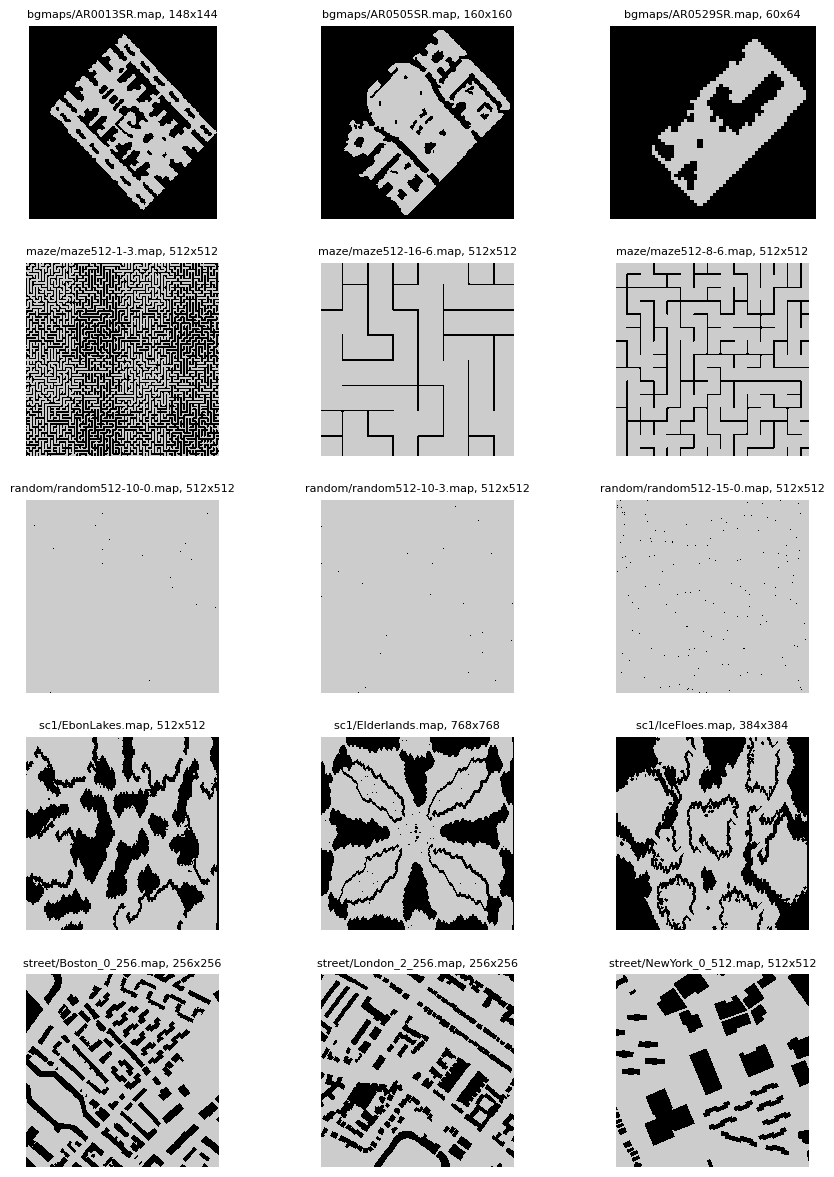

In [33]:
fig, axs = plt.subplots(len(selected_categories), NUM_MAPS, figsize=(9, 12))
fig.tight_layout()

for i, (category, category_problems) in enumerate(sorted(CHOSEN_PROBLEMS.items(), key=lambda x: x[0])):
    for j, (map_, map_problems) in enumerate(sorted(category_problems.items(), key=lambda x: x[0])):
        axs[i, j].axis('off')
        grid = map_problems[0].grid
        if category == "maze":
            grid = grid[20:150, 20:150]
        axs[i, j].imshow(grid, cmap=mpl.colors.ListedColormap(['0.8', 'black']))
        shape = map_problems[0].grid.shape
        axs[i, j].set_title(f"{category}/{map_}, {shape[0]}x{shape[1]}", fontsize=8)

# Бенчмаркинг

Здесь мы измеряем время работы.

Каждая задача запускается `number + 2` раза.

Из первого запуска мы узнаем статистику алгоритма.

Второй используется как setup для `timeit`, это чтобы убедиться,
что все функции скомпилировались к моменту запуска измерений
(у `timeit` есть всякие особенности среды, в которой он исполняет модули).

Затем алгоритм запускается `number` раз, и в статистику записывается среднее время работы.


In [34]:
def benchmark_one(problem: Problem, w, reexpansion=False):
    f = lambda: a_star_and_trace(problem.grid, problem.start, problem.end, w, reexpansion)
    dist, stats, _ = f()
    stats = dict(stats)
    stats["dist"] = dist
    stats["expected_dist"] = problem.expected_answer
    stats["correct"] = np.allclose(dist, problem.expected_answer)
    number = 5
    time = timeit.timeit(f, setup=f, number=number, globals=globals()) / number
    stats["time"] = time
    return stats

Наконец, само измерение. Для большего ускорения я использую `joblib`,
чтобы распараллелить бенчмаркинг на все ядра.

In [35]:
def run_one(problem, w, reexpansion):
    stats = benchmark_one(problem, w, reexpansion)
    return {
        "category": problem.category,
        "map": problem.map_name,
        "problem_id": problem.problem_id,
        "w": w,
        "reexpansion": reexpansion,
        **stats,
    }

args = []
for category, category_problems in CHOSEN_PROBLEMS.items():
    for map, map_problems in category_problems.items():
        for problem in map_problems:
            for w, reexpansion in itertools.product([1.0, 1.05, 1.1, 1.2, 1.5, 2.0, 3.0, 5.0, 10.0, 100.0], [False, True]):
                args.append((problem, w, reexpansion))


jobs = [joblib.delayed(run_one)(*arg) for arg in args]
random.seed(0)
random.shuffle(jobs)

if not Path("stats.csv").exists():
    STATS = joblib.Parallel(n_jobs=-1, verbose=0)(tqdm.tqdm(jobs))
    STATS = pd.DataFrame(STATS)
    STATS.to_csv("stats.csv", index=False)















































































100%|██████████| 300/300 [00:27<00:00, 10.77it/s]


In [36]:
STATS = pd.read_csv("stats.csv")

# Анализ

Начнем с простого: проверим что (почти) эвристики работают.

In [38]:
STATS.groupby(["w", "reexpansion"])[["correct"]].mean()

correct
w      reexpansion          
1.00   False        1.000000
       True         1.000000
1.05   False        0.533333
       True         0.733333
1.10   False        0.400000
       True         0.600000
1.20   False        0.333333
       True         0.466667
1.50   False        0.266667
       True         0.400000
2.00   False        0.200000
       True         0.200000
3.00   False        0.133333
       True         0.133333
5.00   False        0.133333
       True         0.133333
10.00  False        0.133333
       True         0.133333
100.00 False        0.133333
       True         0.133333

Из таблицы видно, что консистентные эвристики на всех тестах отработали правильно.

Неконсистентная эвристика Манхеттенского расстояния отработала правильно только на ~2/3 тестов,
причем если включить перераскрытие, то она начинает работать правильно немного чаще.

Начнем именно с ее исследования.

Посмотрим, на сколько она ошибается. Нарисуем гистограмму ошибок.

Каждый столбец на гистограмме соответствует промежутку отношения полученного расстояния
к истинному, и высота столбца соответствует количеству задач, на которых отношение попало в этот промежуток.

(array([1.117e+03, 7.600e+01, 5.900e+01, 4.000e+01, 3.400e+01, 3.300e+01,
        2.800e+01, 2.500e+01, 1.800e+01, 2.100e+01, 2.100e+01, 5.000e+00,
        6.000e+00, 6.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 1.000e+00]),
 array([1.        , 1.007326  , 1.014652  , 1.021978  , 1.029304  ,
        1.03663   , 1.043956  , 1.051282  , 1.058608  , 1.065934  ,
        1.07326   , 1.080586  , 1.087912  , 1.09523799, 1.10256399,
        1.10988999, 1.11721599, 1.12454199, 1.13186799, 1.13919399,
        1.14651999]),
 <BarContainer object of 20 artists>)

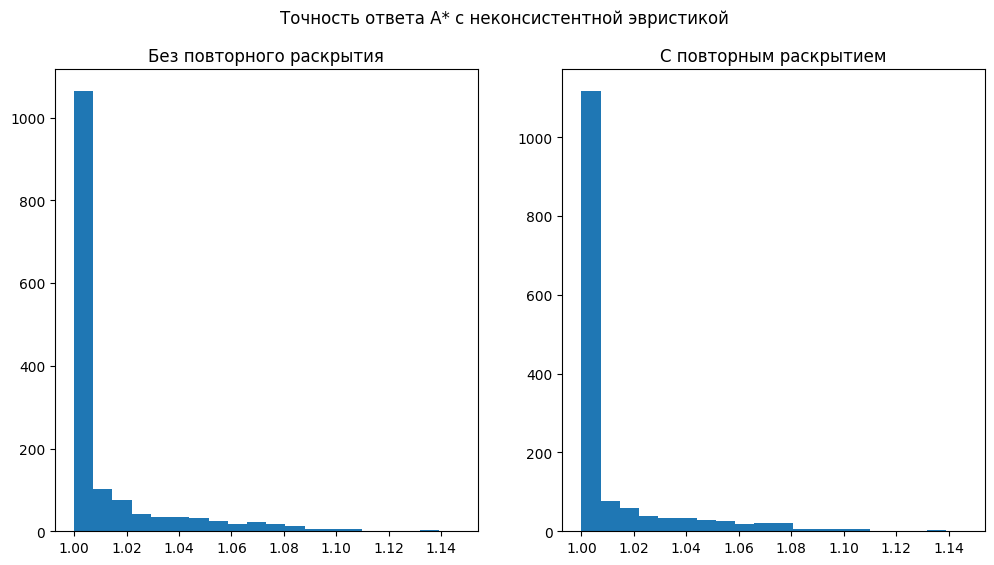

In [15]:
manhatten_no_reexp_stats = STATS[(STATS.heuristic == "manhattan_heuristic") & (STATS.reexpansion == False)]
manhatten_reexp_stats = STATS[(STATS.heuristic == "manhattan_heuristic") & (STATS.reexpansion == True)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Tочность ответа A* с неконсистентной эвристикой")
dist = manhatten_no_reexp_stats[['dist']].values
expected_dist = manhatten_no_reexp_stats[['expected_dist']].values
hist1 = dist / expected_dist
dist = manhatten_reexp_stats[['dist']].values
expected_dist = manhatten_reexp_stats[['expected_dist']].values
hist2 = dist / expected_dist
ax1.title.set_text("Без повторного раскрытия")
ax1.hist(hist1, bins=20)
ax2.title.set_text("C повторным раскрытием")
ax2.hist(hist2, bins=20)


Оказывается, повторное раскрытие почти не влияет на результаты. 

С другой стороны, ошибка не очень и большая. За исключением нескольких выбросов,
она не превышает 10%. Можно сделать вывод, что
неконсистентные эвристики использовать опасно, A* может ошибаться,
но в целом ответ не сильно отличается от истинного, и наверняка в приближенных задачах
лучше использовать их, чем не использовать ничего. А когда их приходится использовать,
не имеет смысла включать перераскрытие.

Теперь разберемся с самой интересной метрикой, с временем работы. Для начала посмотрим на общие тренды с помощью cactus-plot-а, то есть
отсортируем все задачи по времени работы для каждой эвристики и построим графики.

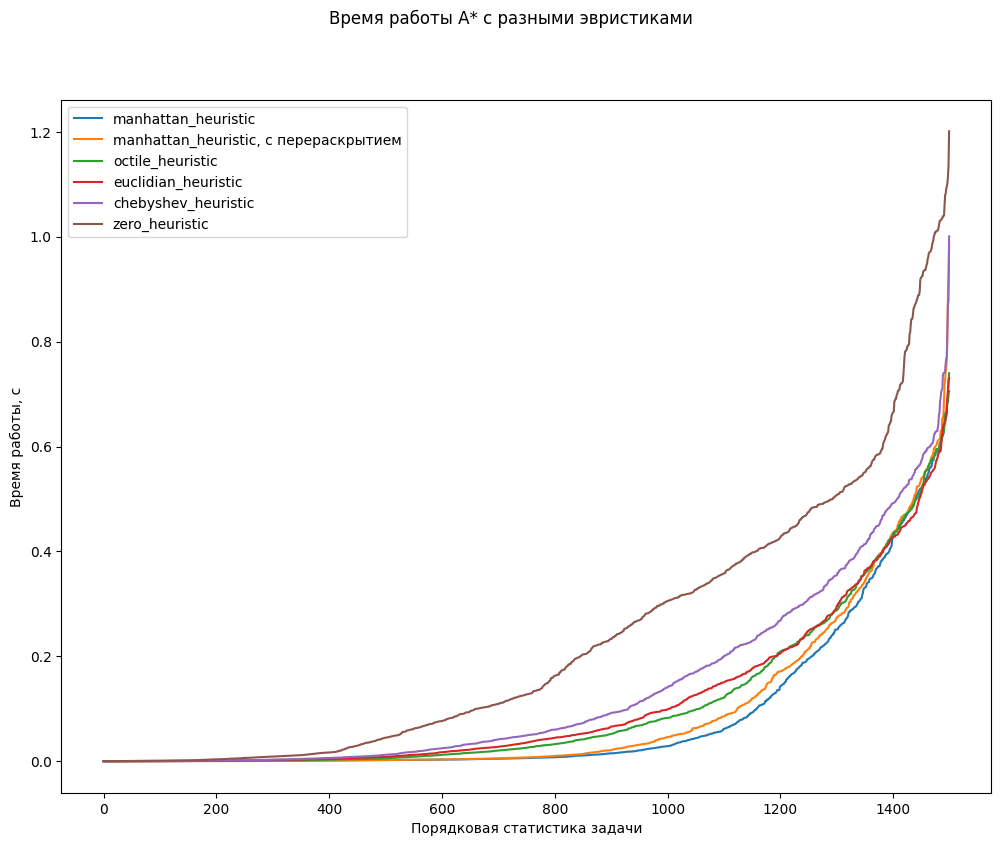

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

fig.suptitle("Время работы A* с разными эвристиками")


HEURISTIC_ORDER = [
    ("manhattan_heuristic", False),
    ("manhattan_heuristic", True),
    ("octile_heuristic", False),
    ("euclidian_heuristic", False),
    ("chebyshev_heuristic", False),
    ("zero_heuristic", False),
]

STATS.loc[:, "h_num"] = -1

for row in STATS.itertuples():
    h_num = HEURISTIC_ORDER.index((row.heuristic, row.reexpansion))
    STATS.at[row.Index, "h_num"] = h_num

for h_num, (heuristic, reexpansion) in enumerate(HEURISTIC_ORDER):
    data = STATS[(STATS.h_num == h_num)]
    ax.plot(np.sort(data.time.values), label=f"{heuristic}{', с перераскрытием' if reexpansion else ''}")

ax.set_ylabel("Время работы, с")
ax.set_xlabel("Порядковая статистика задачи")
ax.legend()

Для начала укажу, что по графику заметен более-менее полный порядок на времени работы между эвристиками,
что говорит о том, что, по сути, вне зависимости от задачи, эвристика решает время работы.

Но давайте подтвердим это: cactus plot не показывает особенности задач, смешивая все в одну кучу.
Какой-то алгоритм с графиком ниже может замечательно себя показывать на задачах другого вида,
с другим графиком. Исправим эту проблему.

Представим, что мы пытаемся угадать порядок, в котором разные эвристики будут работать на задачах,
не смотря на сами задачи. Тогда у нас есть фиксированный порядок: какие-то эвристики, как видны выше, работают лучше.
Рассмотрим этот порядок как предсказание, и посмотрим на confusion matrix этого предсказания.

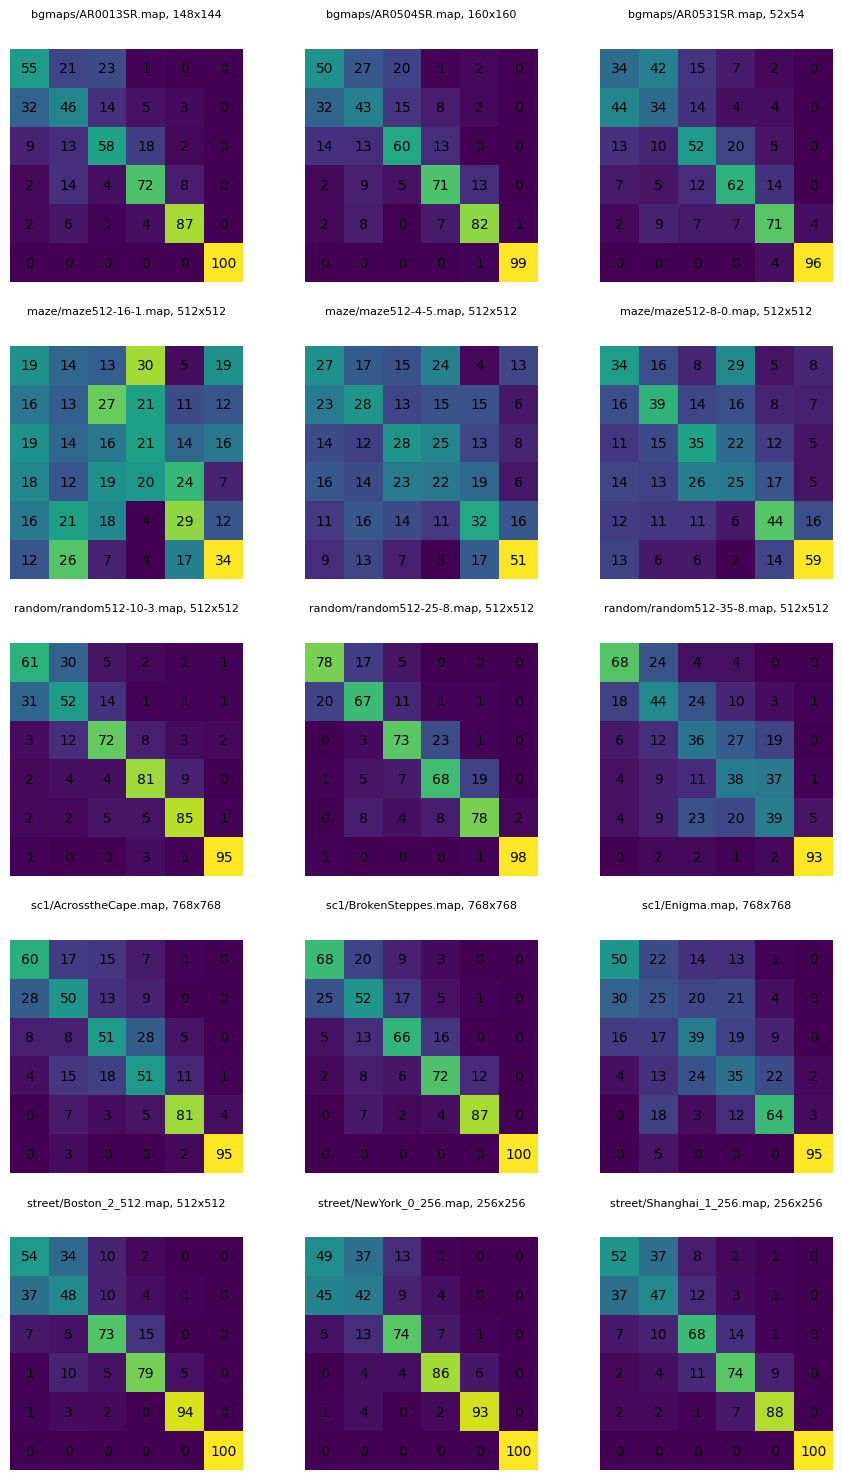

In [17]:
fig, axs = plt.subplots(len(selected_categories), NUM_MAPS, figsize=(9, 15))
fig.tight_layout()

NUM_ALGOS = len(HEURISTIC_ORDER)

for i, (category, category_problems) in enumerate(sorted(CHOSEN_PROBLEMS.items(), key=lambda x: x[0])):
    for j, (map_, map_problems) in enumerate(sorted(category_problems.items(), key=lambda x: x[0])):
        data = STATS[(STATS.category == str(category)) & (STATS["map"] == str(map_))]

        axs[i, j].axis('off')
        shape = map_problems[0].grid.shape
        axs[i, j].set_title(f"{category}/{map_}, {shape[0]}x{shape[1]}", fontsize=8)
        confusion = np.zeros((NUM_ALGOS, NUM_ALGOS), dtype=np.int64)

        for _, group in data.groupby("problem_id"):
            eff = np.zeros(NUM_ALGOS, dtype=np.float64)
            for row in group.itertuples():
                h_num = row.h_num
                eff[h_num] = row.time
            permutation = np.argsort(eff)
            for row in range(len(HEURISTIC_ORDER)):
                confusion[row, permutation[row]] += 1

        axs[i, j].matshow(confusion)
        for (mi, mj), z in np.ndenumerate(confusion):
            axs[i, j].text(mj, mi, z, ha='center', va='center')


На этих матрицах показано то, насколько хорошо эвристики работают на разных картах относительно друг друга.
Число в клетке `(i, j)` равно количеству задач на карте, на которой эвристика i оказалась на месте j
по сравнению с другими эвристиками. Номер эвристики соответствует номеру графика из cactus-plot-а выше:
1. Манхэттен
2. Манхэттен с перераскрытием
3. Диагональная
4. Евклид
5. Чебышев
6. Без эвристики

Видно, как 6-я эвристика, то есть `zero_heuristic` почти всегда доминирует в последнем столбце,
что означает, что Дейкстра почти всегда проигрывает A*.

Однако на задачах из категории maze это не совсем так. Конечно, это все равно доминирующее значение,
но не так сильно. Скорее всего, это связано с тем, что на лабиринтах эвристика не дает большого выигрыша,
так как она очень грубо оценивает настоящее расстояние до цели, игнорируя все стены. Это также объясняет
большой разброс в значениях по разным эвристикам: если на других картах в основном есть
сосредоточение на главной диагонали, то в этом случае как будто не важно, какую эвристику брать.
Тем не менее, видно, что выигрыш от эвристики все равно есть, а разброс по времени не так и велик,
как мы увидим далее.

Похожая картина с меньшим, но все еще большим разбросом наблюдается на карте `sc1/Enigma`. Эта карта и правда
во многом топологически напоминает лабиринт
(в ней есть много ответвлений, которые могут приближать к цели, но не доводить до нее), так что это ожидаемо.

Отмечу также высокий разброс между эвристиками на `random/random512-32-8` - плотной случайно сгенерированной карте.

Что на счет других характеристик?

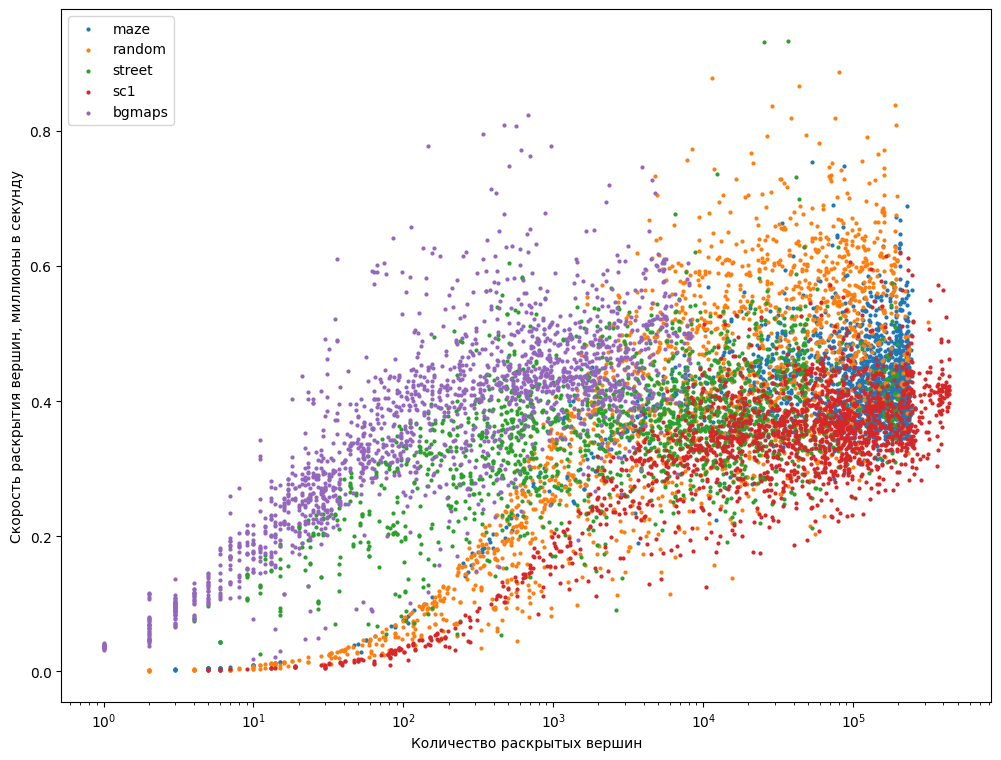

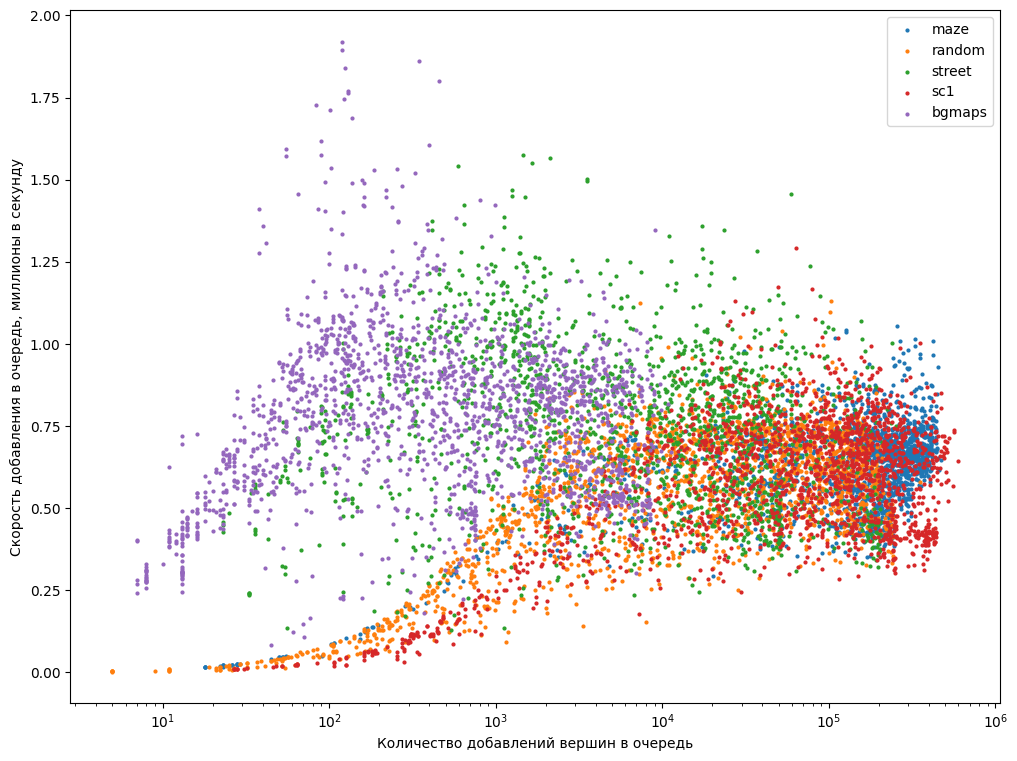

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.set_xscale("log")
ax.set_xlabel("Количество раскрытых вершин")
ax.set_ylabel("Скорость раскрытия вершин, миллионы в секунду")

for category in selected_categories:
    data = STATS[STATS.category == category]
    ax.scatter(data.closed, data.closed / data.time / 1e6, label=category, s=4.0)

ax.legend()


fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.set_xscale("log")
ax.set_xlabel("Количество добавлений вершин в очередь")
ax.set_ylabel("Скорость добавления в очередь, миллионы в секунду")

for category in selected_categories:
    data = STATS[STATS.category == category]
    ax.scatter(data.opened, data.opened / data.time / 1e6, label=category, s=4.0)

ax.legend()


Виден следующий тренд: количество раскрытий и добавлений в очередь коррелирует со временем работы.

На маленьких задачах, конечно, эффект не так заметен, так как большая часть времени работы уходит на инициализацию,
но на больших задачах это уже не так.

Но насколько хорошо мы отсекаем ненужные вершины?

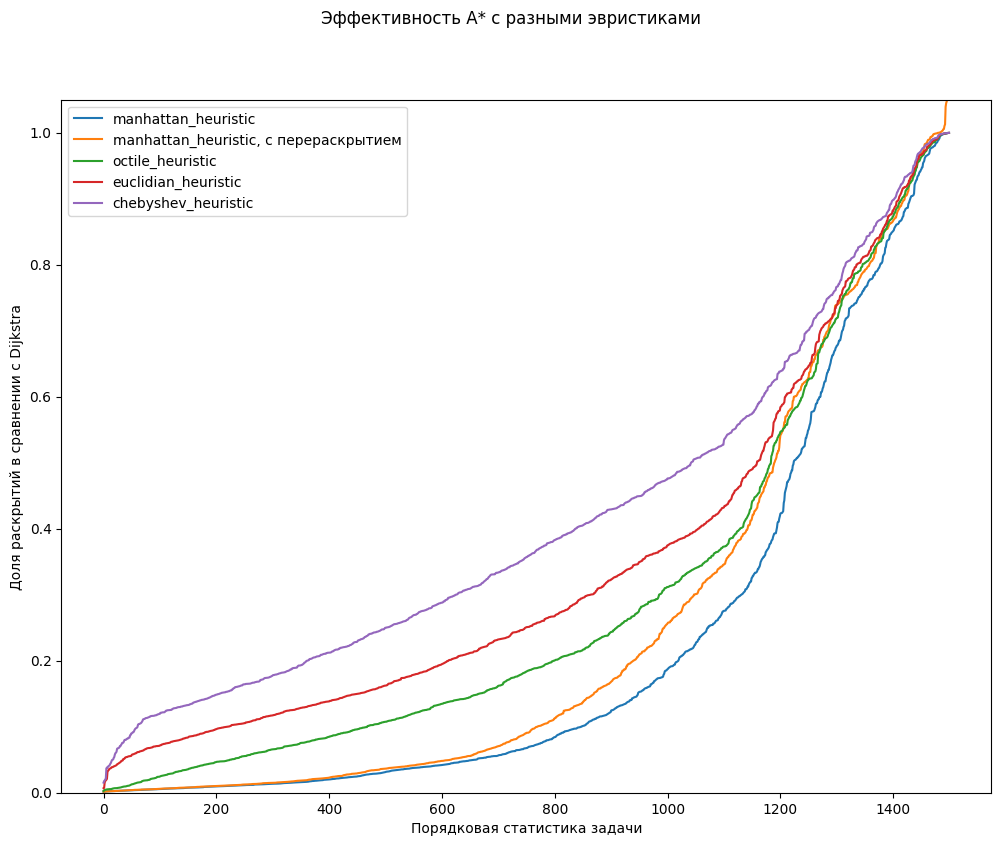

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

fig.suptitle("Эффективность A* с разными эвристиками")


dij_data = STATS[(STATS.h_num == NUM_ALGOS - 1)]

for h_num, (heuristic, reexpansion) in enumerate(HEURISTIC_ORDER[:-1]):
    data = STATS[(STATS.h_num == h_num)]
    ax.plot(np.sort((data.closed.values + 1) / (dij_data.closed.values + 1)), label=f"{heuristic}{', с перераскрытием' if reexpansion else ''}")

ax.set_ylabel("Доля раскрытий в сравнении с Dijkstra")
ax.set_xlabel("Порядковая статистика задачи")
ax.set_ylim(0, 1.05)
ax.legend()

Здесь наблюдаемый тренд еще более явный: эвристика очень хорошо определяет эффективность алгоритма, причем порядок
такой же, как и при измерении времени.


Эта определенность выражается и в confusion матрицах количества раскрытий.

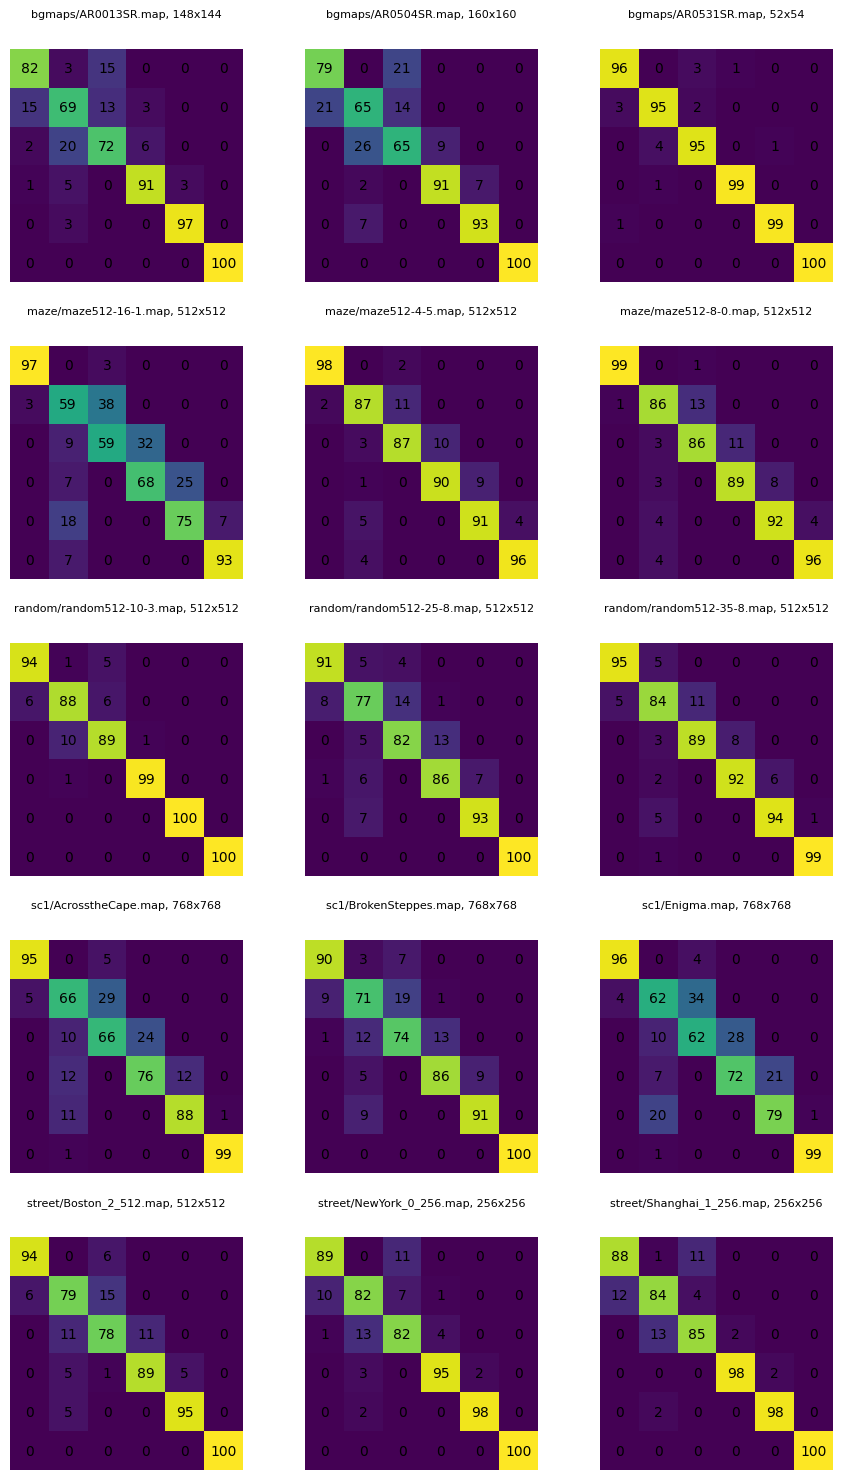

In [20]:
fig, axs = plt.subplots(len(selected_categories), NUM_MAPS, figsize=(9, 15))
fig.tight_layout()

NUM_ALGOS = len(HEURISTIC_ORDER)

for i, (category, category_problems) in enumerate(sorted(CHOSEN_PROBLEMS.items(), key=lambda x: x[0])):
    for j, (map_, map_problems) in enumerate(sorted(category_problems.items(), key=lambda x: x[0])):
        data = STATS[(STATS.category == str(category)) & (STATS["map"] == str(map_))]

        axs[i, j].axis('off')
        shape = map_problems[0].grid.shape
        axs[i, j].set_title(f"{category}/{map_}, {shape[0]}x{shape[1]}", fontsize=8)
        confusion = np.zeros((NUM_ALGOS, NUM_ALGOS), dtype=np.int64)

        for _, group in data.groupby("problem_id"):
            eff = np.zeros(NUM_ALGOS, dtype=np.float64)
            for row in group.itertuples():
                h_num = row.h_num
                eff[h_num] = row.closed
            permutation = np.argsort(eff)
            for row in range(len(HEURISTIC_ORDER)):
                confusion[row, permutation[row]] += 1

        axs[i, j].matshow(confusion)
        for (mi, mj), z in np.ndenumerate(confusion):
            axs[i, j].text(mj, mi, z, ha='center', va='center')

Как я и говорил, время работы сильно коррелирует с количеством раскрытий,
а так как эвристика определяет количество раскрытий, то она и определяет время работы.
Мы видим, элементы матрицы сосредоточены на диагоналях, то есть разброс между эвристиками очень мал.

Из этого я делаю вывод, что разброс по времени, когда мы смотрели на confusion матрицы по времени,
тоже не так велик, и хотя элементы разбросаны по матрице на некоторых картах, это скорее всего
случайность времени работы, а не эффективности алгоритма.

# Выводы!

Мы проанализировали A* с разными эвристиками и выяснили, что эвристика действительно
определяет эффективность алгоритма.

Манхеттенская эвристика дает наилучшие результаты, но на гриде с 8 соседями она не является
консистентной и выдает неправильные результаты. Однако, ошибка не слишком велика, и в приближенных
задачах использовать ее все равно лучше, чем не использовать ничего. Если ее использовать,
не имеет смысла добавлять перераскрытие.

Диагональная эвристика дает хорошие результаты и по производительности, и по количеству раскрытий,
обгоняя остальные эвристики. Это разумный выбор для такой задачи, так как эта эвристика наиболее
качественно оценивает расстояние до цели.

Чуть хуже работает евклидова эвристика, за ней идет чебышевская.

Наконец, A* без эвристики, вырождающийся в Дейкстру, работает плохо,
и как правило проигрывает остальным эвристикам. Получается, в задачах, где A*
применим, почти всегда лучше использовать какую-нибудь эвристику, чем не использовать ничего.

На задачах из категории maze и на карте `sc1/Enigma` эвристика не дает большого выигрыша,
так как она слишком грубо оценивает расстояние до цели, игнорируя все стены.

Количество раскрытий коррелирует со временем работы, но является гораздо более
стабильной метрикой, чем время работы.